# Model Monitor with BYO XGBoost Containers

In this notebook, we will walk through how to build your own custom XGBoost Container and set up Model Monitoring on the deployed endpoint. We will also demonstrate, how to use SageMaker Processing to build a custom data processing pipeline, and use SageMaker Debugger to create custom rules that monitor your model during training.

### Download and import necessary libraries

In [1]:
!pip install --upgrade pip
!pip install sagemaker-experiments 
#!pip install smdebug
!pip install boto3 --upgrade
!pip install xgboost==0.90

     |████████████████████████████████| 1.5 MB 19.7 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
     |████████████████████████████████| 129 kB 15.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.5 MB 32.5 MB/s eta 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.17.27
    Uninstalling botocore-1.17.27:
      Successfully uninstalled botocore-1.17.27
  Attempting uninstall: boto3
    Found existing installation: boto3 1.14.27
    Uninstalling boto3-1.14.27:
      Successfully uninstalled boto3-1.14.27
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

awscli 1.18.104 requires botocore==

### Restart Kernel

Once the libraries are installed, restart the kernel by clicking Kernel --> Restart and Running all the cells below.

In [1]:
# Let's inspect the role we have created for our notebook here:
import boto3
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.session.Session().region_name
print("Region = {}".format(region))
sm = boto3.Session().client('sagemaker')

Region = us-east-1


### Complete Setup: Import libraries and set global definitions.

All needed libraries will come pre-installed with this notebook with the Lifecycle configuration scripts.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import sleep, gmtime, strftime
import json
import time

In [3]:
# Import SageMaker Experiments 

from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

### Specify buckets for storing data

In [4]:
# Use our custom bucket here. 
rawbucket= sess.default_bucket()
prefix = 'sagemaker-modelmonitor' # use this prefix to store all files pertaining to this workshop.

dataprefix = prefix + '/data'
traindataprefix = prefix + '/train_data'
testdataprefix = prefix + '/test_data'
trainheaderprefix = prefix + '/train_headers'

# Pre-processing and Feature Engineering

A key part of the data science lifecyle is data exploration, pre-processing and feature engineering. We will demonstrate how to use SM notebooks for data exploration and SM Processing for feature engineering and pre-processing data

### Download and Import the data

In [5]:
data = pd.read_excel('credit_card_default_data.xls', header=1)
data = data.drop(columns = ['ID'])
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# Note that the categorical columns SEX, Education and Marriage have been Integer Encoded in this case.
# For example:
data.SEX.value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [7]:
data.rename(columns={"default payment next month": "Label"}, inplace=True)
lbl = data.Label
data = pd.concat([lbl, data.drop(columns=['Label'])], axis = 1)
data.head()

,Label,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


### Data Exploration

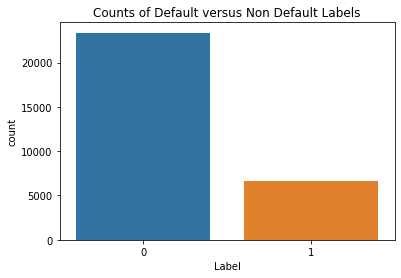

In [8]:
import seaborn as sns
sns.countplot(data.Label)
plt.title('Counts of Default versus Non Default Labels')
plt.show()

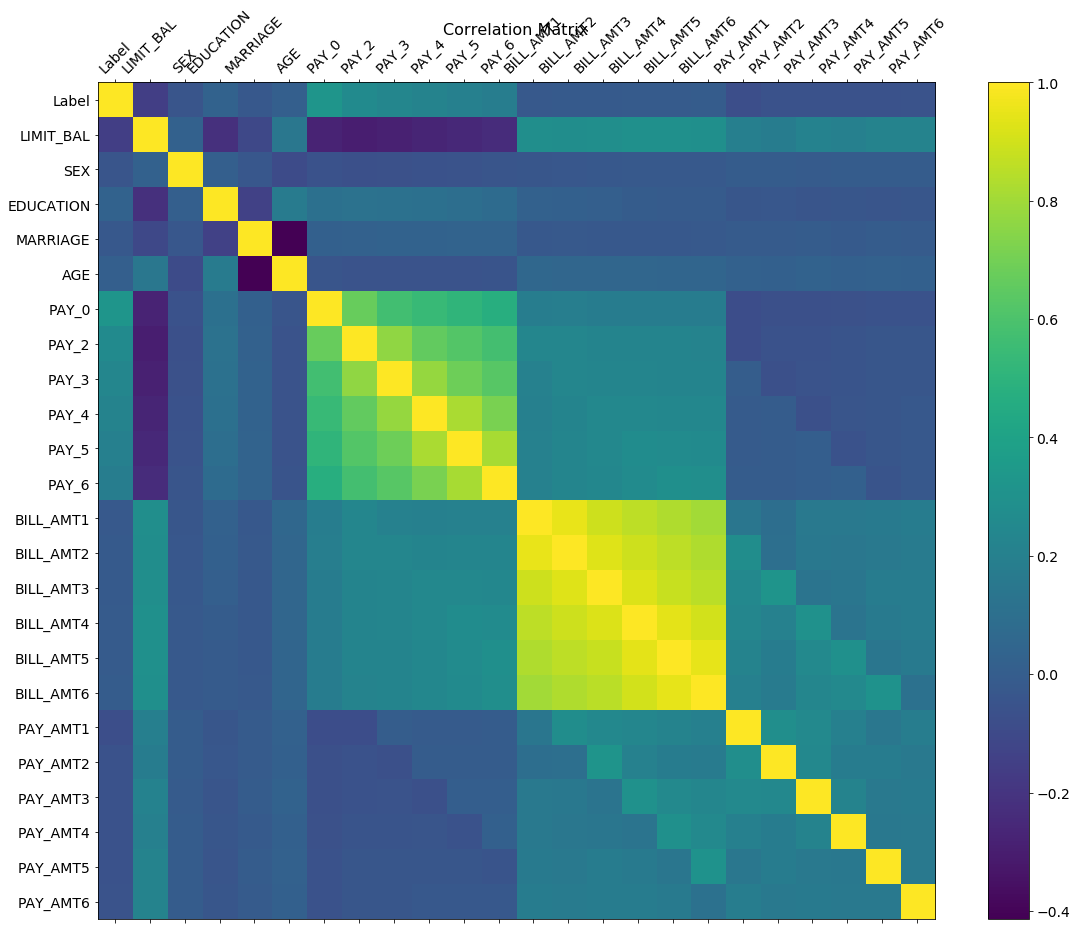

In [9]:
## Corr plot
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

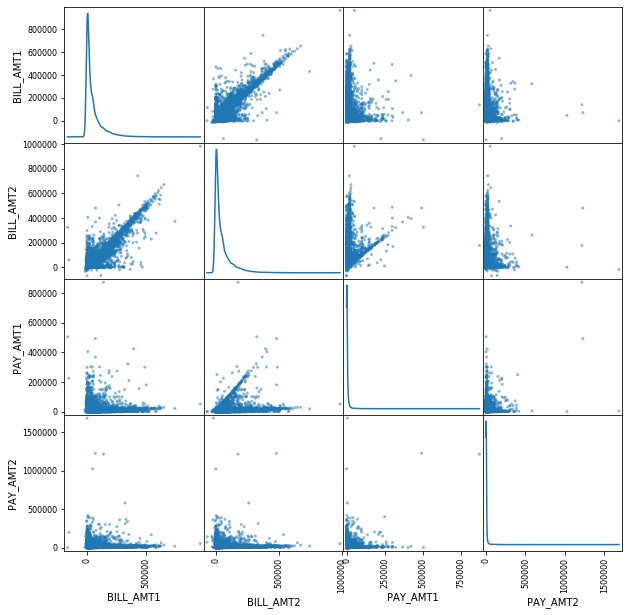

In [10]:
from pandas.plotting import scatter_matrix
SCAT_COLUMNS = ['BILL_AMT1', 'BILL_AMT2', 'PAY_AMT1', 'PAY_AMT2']
scatter_matrix(data[SCAT_COLUMNS],figsize=(10, 10), diagonal ='kde')
plt.show()

### Preprocessing and Feature Engineering in Notebook

In [ ]:
if not os.path.exists('rawdata/rawdata.csv'):
    !mkdir rawdata
    data.to_csv('rawdata/rawdata.csv', index=None)
else:
    pass

In [ ]:
# Upload the raw dataset
raw_data_location = sess.upload_data('rawdata', bucket=rawbucket, key_prefix=dataprefix)
print(raw_data_location)

In [ ]:
# Run the preprocessing job in the notebook and upload the training and validation datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer

COLS = data.columns
X_train, X_test, y_train, y_test = train_test_split(data.drop('Label', axis=1), data['Label'], 
                                                       test_size=0.2, random_state=0)
newcolorder = ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]

preprocess = make_column_transformer(
        (StandardScaler(), ['PAY_AMT1']),
        (MinMaxScaler(), ['BILL_AMT1']),
    remainder='passthrough')
    
print('Running preprocessing and feature engineering transformations')
train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns = newcolorder)
test_features = pd.DataFrame(preprocess.transform(X_test), columns = newcolorder)

train_full = pd.concat([pd.DataFrame(y_train.values, columns=['Label']), pd.DataFrame(train_features)], axis=1)
test_full = pd.concat([pd.DataFrame(y_test.values, columns=['Label']), pd.DataFrame(test_features)], axis=1)
train_full.to_csv('train_data.csv', index=False, header=False)
test_full.to_csv('test_data.csv', index=False, header=False)                                                   
train_full.to_csv('train_data_with_headers.csv', index=False)                                                    

In [ ]:
# Upload data
train_data_header_location = sess.upload_data('train_data_with_headers.csv', bucket=rawbucket, key_prefix=trainheaderprefix)
train_data_location = sess.upload_data('train_data.csv', bucket=rawbucket, key_prefix=traindataprefix)
test_data_location = sess.upload_data('test_data.csv', bucket=rawbucket, key_prefix=testdataprefix)

### Secure Feature Processing pipeline using SageMaker Processing

While you can pre-process small amounts of data directly in a notebook as shown above, SageMaker Processing offloads the heavy lifting of pre-processing larger datasets by provisioning the underlying infrastructure, downloading the data from an S3 location to the processing container, running the processing scripts, storing the processed data in an output directory in Amazon S3 and deleting the underlying transient resources needed to run the processing job. Once the processing job is complete, the infrastructure used to run the job is wiped, and any temporary data stored on it is deleted.

In [ ]:
## Use SageMaker Processing with Sk Learn. -- combine data into train and test at this stage if possible.
from sagemaker.sklearn.processing import SKLearnProcessor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.c4.xlarge',
                                     instance_count=1) 

### Write a preprocessing script (same as above)

In [ ]:
%%writefile preprocessing.py

import argparse
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import DataConversionWarning
from sklearn.compose import make_column_transformer

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

if __name__=='__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--train-test-split-ratio', type=float, default=0.3)
    parser.add_argument('--random-split', type=int, default=0)
    args, _ = parser.parse_known_args()
    
    print('Received arguments {}'.format(args))

    input_data_path = os.path.join('/opt/ml/processing/input', 'rawdata.csv')
    
    print('Reading input data from {}'.format(input_data_path))
    df = pd.read_csv(input_data_path)
    df.sample(frac=1)
    
    COLS = df.columns
    newcolorder = ['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
    
    split_ratio = args.train_test_split_ratio
    random_state=args.random_split
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Label', axis=1), df['Label'], 
                                                        test_size=split_ratio, random_state=random_state)
    
    preprocess = make_column_transformer(
        (['PAY_AMT1'], StandardScaler()),
        (['BILL_AMT1'], MinMaxScaler()),
    remainder='passthrough')
    
    print('Running preprocessing and feature engineering transformations')
    train_features = pd.DataFrame(preprocess.fit_transform(X_train), columns = newcolorder)
    test_features = pd.DataFrame(preprocess.transform(X_test), columns = newcolorder)
    
    # concat to ensure Label column is the first column in dataframe
    train_full = pd.concat([pd.DataFrame(y_train.values, columns=['Label']), train_features], axis=1)
    test_full = pd.concat([pd.DataFrame(y_test.values, columns=['Label']), test_features], axis=1)
    
    print('Train data shape after preprocessing: {}'.format(train_features.shape))
    print('Test data shape after preprocessing: {}'.format(test_features.shape))
    
    train_features_headers_output_path = os.path.join('/opt/ml/processing/train_headers', 'train_data_with_headers.csv')
    
    train_features_output_path = os.path.join('/opt/ml/processing/train', 'train_data.csv')
    
    test_features_output_path = os.path.join('/opt/ml/processing/test', 'test_data.csv')
    
    print('Saving training features to {}'.format(train_features_output_path))
    train_full.to_csv(train_features_output_path, header=False, index=False)
    print("Complete")
    
    print("Save training data with headers to {}".format(train_features_headers_output_path))
    train_full.to_csv(train_features_headers_output_path, index=False)
                 
    print('Saving test features to {}'.format(test_features_output_path))
    test_full.to_csv(test_features_output_path, header=False, index=False)
    print("Complete")
    

In [ ]:
# Copy the preprocessing code over to the s3 bucket
codeprefix = prefix + '/code'
codeupload = sess.upload_data('preprocessing.py', bucket=rawbucket, key_prefix=codeprefix)
print(codeupload)

In [ ]:
train_data_location = rawbucket + '/' + traindataprefix
test_data_location = rawbucket+'/'+testdataprefix
print("Training data location = {}".format(train_data_location))
print("Test data location = {}".format(test_data_location))

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor.run(code=codeupload,
                      inputs=[ProcessingInput(
                        source=raw_data_location,
                        destination='/opt/ml/processing/input')],
                      outputs=[ProcessingOutput(output_name='train_data',
                                                source='/opt/ml/processing/train',
                               destination='s3://' + train_data_location),
                               ProcessingOutput(output_name='test_data',
                                                source='/opt/ml/processing/test',
                                               destination="s3://"+test_data_location),
                               ProcessingOutput(output_name='train_data_headers',
                                                source='/opt/ml/processing/train_headers',
                                               destination="s3://" + rawbucket + '/' + prefix + '/train_headers')],
                      arguments=['--train-test-split-ratio', '0.2']
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'train_data':
        preprocessed_training_data = output['S3Output']['S3Uri']
    if output['OutputName'] == 'test_data':
        preprocessed_test_data = output['S3Output']['S3Uri']

# Model development and Training

## Traceability and Auditability 

We use SageMaker Experiments for data scientists to track the lineage of the model from the raw data source to the preprocessing steps and the model training pipeline. With SageMaker Experiments, data scientists can compare, track and manage multiple diferent model training jobs, data processing jobs, hyperparameter tuning jobs and retain a lineage from the source data to the training job artifacts to the model hyperparameters and any custom metrics that they may want to monitor as part of the model training.

As we demonstrate here, SageMaker Experiments works with Bring-Your-Own-Container in addition to SageMaker algorithms. 

In [ ]:
# Create a SageMaker Experiment
cc_experiment = Experiment.create(
    experiment_name=f"CreditCardDefault-{int(time.time())}", 
    description="Predict credit card default from payments data", 
    sagemaker_boto_client=sm)
print(cc_experiment)


In [ ]:
# Start Tracking parameters used in the Pre-processing pipeline.
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "train_test_split_ratio": 0.2,
        "random_state":0
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(name="ccdefault-train-dataset", media_type="s3/uri", value=train_data_location)
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_data_location)
    

### Build XgBoost container for training

The code for the XGB container is already supplied with this notebook. We simply need to build this container and push it to ECR. 

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=sagemaker-xgboost

cd container

chmod +x xgboost/train
chmod +x xgboost/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-east-1 if none defined)
region=$(aws configure get region)
region=${region:-us-east-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}


### Train the Model

The same security postures we applied previously during SM Processing apply to training jobs. We will also have SageMaker experiments track the training job and store metadata such as model artifact location, training/validation data location, model hyperparameters etc.


In [ ]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
image = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-xgboost:latest'.format(account, region)
preprocessing_trial_component = tracker.trial_component

trial_name = f"cc-fraud-training-job-{int(time.time())}"
cc_trial = Trial.create(
        trial_name=trial_name, 
            experiment_name=cc_experiment.experiment_name,
        sagemaker_boto_client=sm
    )

cc_trial.add_trial_component(preprocessing_trial_component)
cc_training_job_name = "cc-training-job-{}".format(int(time.time()))

xgb = sagemaker.estimator.Estimator(image,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    train_max_run=86400,
                                    output_path='s3://{}/{}/models'.format(rawbucket, prefix),
                                    sagemaker_session=sess) # set to true for distributed training

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        verbosity=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit(inputs = {'training':"s3://" + train_data_location},
       job_name=cc_training_job_name,
        experiment_config={
            "TrialName": cc_trial.trial_name, #log training job in Trials for lineage
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
time.sleep(2)


##  5. Traceability and Auditability from source control to Model artifacts

Having used SageMaker Experiments to track the training runs, we can now extract model metadata to get the entire lineage of the model from the source data to the model artifacts and the hyperparameters.

To do this, simply call the **describe_trial_component** API.

In [ ]:
# Present the Model Lineage as a dataframe
from sagemaker.session import Session
sess = boto3.Session()
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": trial_name
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)
lineagedf= lineage_table.dataframe()

lineagedf

In [ ]:
# get detailed information about a particular trial
sm.describe_trial_component(TrialComponentName=lineagedf.TrialComponentName[1])

## 6 Explainability and Interpretability

We use SHAP values to understand which features contribute most to the model performance,

First we use some custom utilities to download and unpack the model locally

In [ ]:
import xgboost as xgb

In [ ]:
from util import utilsspec
OUTPUT_ARTIFACTS = lineagedf.TrialComponentName[1]
LOCAL_FILENAME = 'cc-model.tar.gz' # training local file
utilsspec.download_artifacts(OUTPUT_ARTIFACTS, LOCAL_FILENAME) # download training file to local SageMaker volume
model = utilsspec.unpack_model_file(LOCAL_FILENAME) # extract the XGB model

In [ ]:
!pip install shap
import shap

In [ ]:
traindata = pd.read_csv('train_data.csv', names = ['Label']+newcolorder)
traindata.head()

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(traindata.drop(columns =['Label'])) # or use SHAP values.

In [ ]:
shap.summary_plot(shap_values, traindata.drop(columns =['Label']), plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, traindata.drop(columns =['Label']))

# Model Deployment and Monitoring

In this notebook, we demonstrate how to manually deploy a DevOps workflow from taking the model we trained in the previous notebook and deploying it into production and monitoring the model endpoint. 

In [ ]:
# Import Model Monitor API
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker import RealTimePredictor
from sagemaker.predictor import csv_serializer

In [ ]:
sm_client = boto3.client('sagemaker')

latest_training_job = sm_client.list_training_jobs(MaxResults=1,
                                                SortBy='CreationTime',
                                                SortOrder='Descending')

training_job_name=TrainingJobName=latest_training_job['TrainingJobSummaries'][0]['TrainingJobName']

training_job_description = sm_client.describe_training_job(TrainingJobName=training_job_name)

model_data = training_job_description['ModelArtifacts']['S3ModelArtifacts']
container_uri = training_job_description['AlgorithmSpecification']['TrainingImage']

# create a model.
def create_model(role, model_name, container_uri, model_data):
    return sm_client.create_model(
        ModelName=model_name,
        PrimaryContainer={
        'Image': container_uri,
        'ModelDataUrl': model_data,
        },
        ExecutionRoleArn=role)
    

try:
    model = create_model(role, training_job_name, container_uri, model_data)
except Exception as e:
        sm_client.delete_model(ModelName=training_job_name)
        model = create_model(role, training_job_name, container_uri, model_data)
        

print('Model created: '+model['ModelArn'])


In [ ]:
s3_capture_upload_path = 's3://{}/{}/monitoring/datacapture'.format(rawbucket, prefix)
data_capture_configuration = {
    "EnableCapture": True,
    "InitialSamplingPercentage": 100,
    "DestinationS3Uri": s3_capture_upload_path,
    "CaptureOptions": [
        { "CaptureMode": "Output" },
        { "CaptureMode": "Input" }
    ],
    "CaptureContentTypeHeader": {
       "CsvContentTypes": ["text/csv"],
       "JsonContentTypes": ["application/json"]}
}

In [ ]:
def create_endpoint_config(endpoint_name, data_capture_config): 
    return sm_client.create_endpoint_config(
                                                EndpointConfigName=training_job_name,
                                                ProductionVariants=[
                                                        {
                                                            'VariantName': 'AllTraffic',
                                                            'ModelName': training_job_name,
                                                            'InitialInstanceCount': 1,
                                                            'InstanceType': 'ml.m4.xlarge',
                                                            'InitialVariantWeight': 1.0,
                                                },
                                                    
                                                    ],
                                                DataCaptureConfig=data_capture_config
                                                )




try:
    endpoint_config = create_endpoint_config(training_job_name, data_capture_configuration)
except Exception as e:
    sm_client.delete_endpoint_config(EndpointConfigName=training_job_name)
    endpoint_config = create_endpoint_config(training_job_name, data_capture_configuration)

print('Endpoint configuration created: '+ endpoint_config['EndpointConfigArn'])


In [ ]:
# Enable data capture, sampling 100% of the data for now. Next we deploy the endpoint in the correct VPC.
def create_endpoint(endpoint_name, config_name):
    return sm_client.create_endpoint(
                                    EndpointName=endpoint_name,
                                    EndpointConfigName=training_job_name
                                )


try:
    endpoint = create_endpoint(training_job_name, endpoint_config)
except Exception as e:
    sm_client.delete_endpoint(EndpointName=training_job_name)
    endpoint = create_endpoint(training_job_name, endpoint_config)

print('Endpoint created: '+ endpoint['EndpointArn'])

In [ ]:
while sm_client.describe_endpoint(EndpointName=training_job_name)['EndpointStatus']=='Creating':
    print(sm_client.describe_endpoint(EndpointName=training_job_name)['EndpointStatus'])
    time.sleep(10)
print("Endpoint set up")

In [ ]:
predictor = RealTimePredictor(training_job_name, content_type = 'text/csv')

!head -10 test_data.csv > test_sample.csv

with open('test_sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        response = predictor.predict(data=payload[2:])
        sleep(0.5)
print('done!')


### View the captured data and test data capture process

You may need to rerun this next cell if you get an error: NoneType Object not iterable

In [ ]:
# Extract the captured json files.
data_capture_prefix = '{}/monitoring/datacapture'.format(prefix)
s3_client = boto3.Session().client('s3')
current_endpoint_capture_prefix = '{}/{}/AllTraffic'.format(data_capture_prefix, training_job_name)
result = s3_client.list_objects(Bucket=rawbucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
print("Found Capture Files:")
print("\n ".join(capture_files))


capture_files[0]

In [ ]:
# View contents of the captured file.
def get_obj_body(bucket, obj_key):
    return s3_client.get_object(Bucket=rawbucket, Key=obj_key).get('Body').read().decode("utf-8")

capture_file = get_obj_body(rawbucket, capture_files[-1])
print(json.dumps(json.loads(capture_file.split('\n')[5]), indent = 2, sort_keys =True))


## 7 Real time Model monitoring

In [ ]:
# copy over the training dataset to Amazon S3 (if you already have it in Amazon S3, you could reuse it).
# Everything is logged in a separate bucket -- that devs who deploy models should be able to access but not necessarily
# data science teams.

# The model bucket can be used to make API calls to the captured Monitoring artifacts. Can also be used to log
# Monitoring calls made for that model.

model_prefix = prefix + "/" + training_job_name
baseline_prefix = model_prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(rawbucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(rawbucket, baseline_results_prefix)
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))


In [ ]:
train_data_header_location = "s3://" + rawbucket + '/' + prefix + '/train_headers'
print(train_data_header_location)

### Start a baselining job

First set up a baseline job with Model Monitor. In the backend, ModelMonitor uses a managed container with the deequ library to determine the statistics of the input training data. To do this, we pass the training data with the headers generated above.

In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600)

my_default_monitor.suggest_baseline(
    baseline_dataset=os.path.join(train_data_header_location, 'train_data_with_headers.csv'),
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True
)

In [ ]:
s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=rawbucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Files:")
print("\n ".join(report_files))

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df

In [ ]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])


### Create a Monitoring Schedule

In [ ]:
code_prefix = '{}/code'.format(prefix)
reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(rawbucket,reports_prefix)
print(s3_report_path)

In [ ]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = 'BYO-xgb-credit-score-model-monitor-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,

)


### Generate artificial traffic for demo purposes

We will modify the distribution of a few colums. form the original test set and repeatedly invoke the endpoint with this new payload. 

In [ ]:
# load the test dataset sample
test_sample = pd.read_csv('test_sample.csv', names = ['Label'] +['PAY_AMT1','BILL_AMT1'] + list(COLS[1:])[:11] + list(COLS[1:])[12:17] + list(COLS[1:])[18:]
)
test_sample.head()

In [ ]:
#Store the test data with one column randomly having negative values for Marriage. 
faketestdata = test_sample
faketestdata['EDUCATION'] = -faketestdata['EDUCATION'].astype(float)
faketestdata['BILL_AMT2']= (faketestdata['BILL_AMT2']//10).astype(float)
faketestdata['AGE']= (faketestdata['AGE']-10).astype(float)

faketestdata.head()


In [ ]:
# save the dataset
faketestdata.drop(columns=['Label']).to_csv('test-data-input-cols.csv', index = None, header=None)

In [ ]:
from threading import Thread

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                          ContentType='text/csv', 
                                          Body=payload)
            time.sleep(1)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(training_job_name, 'test-data-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()
# Note that you need to stop the kernel to stop the invocations
invoke_endpoint(training_job_name, 'test-data-input-cols.csv', runtime_client)

In [ ]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))


### List Model Monitor Outputs

This process will take time as the Model Monitoring will run an execution every hour or so. It may take up to 20 mins for the first execution to run and an output to be visible in the APIs below.

Go grab a coffee, lunch, catch up on emails or grab a stretch. 

In [ ]:
mon_executions = my_default_monitor.list_executions()
print("We created ahourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(600)
    mon_executions = my_default_monitor.list_executions()

Once the Monitoring job is complete, you should see a json formatted output like here:


{'ProcessingInputs': [{'InputName': 'input_1',
   'S3Input': {'S3Uri': 's3://{}/sagemaker-modelmonitor/monitoring/datacapture/cc-training-job-1585663797/AllTraffic/2020/03/31/14',
    'LocalPath': '/opt/ml/processing/input/endpoint/cc-training-job-1585663797/AllTraffic/2020/03/31/14',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'baseline',
   'S3Input': {'S3Uri': 's3://{}/sagemaker-modelmonitor/cc-training-job-1585663797/baselining/results/statistics.json',
    'LocalPath': '/opt/ml/processing/baseline/stats',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'constraints',
   'S3Input': {'S3Uri': 's3://{}/sagemaker-modelmonitor/cc-training-job-1585663797/baselining/results/constraints.json',
    'LocalPath': '/opt/ml/processing/baseline/constraints',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3://{}/sagemaker-modelmonitor/reports/cc-training-job-1585663797/BYO-xgb-credit-score-model-monitor-schedule-2020-03-31-14-54-12/2020/03/31/15',
     'LocalPath': '/opt/ml/processing/output',
     'S3UploadMode': 'Continuous'}}]},
 'ProcessingJobName': 'model-monitoring-202003311500-0571748e9969313bbe1b3bfd',
 'ProcessingResources': {'ClusterConfig': {'InstanceCount': 1,
   'InstanceType': 'ml.m5.xlarge',
   'VolumeSizeInGB': 20}},
 'StoppingCondition': {'MaxRuntimeInSeconds': 3600},
 'AppSpecification': {'ImageUri': '777275614652.dkr.ecr.us-east-2.amazonaws.com/sagemaker-model-monitor-analyzer'},
 'Environment': {'baseline_constraints': '/opt/ml/processing/baseline/constraints/constraints.json',
  'baseline_statistics': '/opt/ml/processing/baseline/stats/statistics.json',
  'dataset_format': '{"sagemakerCaptureJson":{"captureIndexNames":["endpointOutput","endpointInput"]}}',
  'dataset_source': '/opt/ml/processing/input/endpoint',
  'end_time': '2020-03-31T15:00:00Z',
  'output_path': '/opt/ml/processing/output',
  'publish_cloudwatch_metrics': 'Enabled',
  'sagemaker_endpoint_name': 'cc-training-job-1585663797',
  'sagemaker_monitoring_schedule_name': 'BYO-xgb-credit-score-model-monitor-schedule-2020-03-31-14-54-12',
  'start_time': '2020-03-31T14:00:00Z'},
 'RoleArn': '{}',
 'ProcessingJobArn': 'arn:aws:sagemaker:{}:processing-job/model-monitoring-202003311500-0571748e9969313bbe1b3bfd',
 'ProcessingJobStatus': 'InProgress',
 'ProcessingStartTime': datetime.datetime(2020, 3, 31, 15, 11, 28, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2020, 3, 31, 15, 11, 28, 408000, tzinfo=tzlocal()),
 'CreationTime': datetime.datetime(2020, 3, 31, 15, 8, 24, 255000, tzinfo=tzlocal()),
 'MonitoringScheduleArn': 'arn:aws:sagemaker:{}:monitoring-schedule/byo-xgb-credit-score-model-monitor-schedule-2020-03-31-14-54-12',
 'ResponseMetadata': {'RequestId': 'c224933e-0c1d-4b1a-a63b-42f3b45833a4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c224933e-0c1d-4b1a-a63b-42f3b45833a4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2884',
   'date': 'Tue, 31 Mar 2020 15:12:01 GMT'},
  'RetryAttempts': 0}}

In [ ]:
mon_executions[-1].describe()

### Inspect the latest execution and generate a report.

All the API calls used here can be implemented separately using API Gateway or other tools. ModelMonitor can also be set up to send alerts and notifications through CloudWatch whenever drift is detected.

In [ ]:
latest_execution = mon_executions[-1] # latest execution's index is -1, second to last is -2 and so on..
time.sleep(60)
latest_execution.wait(logs=False)

print("Latest execution status: {}".format(latest_execution.describe()['ProcessingJobStatus']))
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))

latest_job = latest_execution.describe()
if (latest_job['ProcessingJobStatus'] != 'Completed'):
        print("====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures.")

In [ ]:
report_uri=latest_execution.output.destination
print('Report Uri: {}'.format(report_uri))

In [ ]:
from urllib.parse import urlparse
s3uri = urlparse(report_uri)
report_bucket = s3uri.netloc
report_key = s3uri.path.lstrip('/')
print('Report bucket: {}'.format(report_bucket))
print('Report key: {}'.format(report_key))

s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=rawbucket, Prefix=report_key)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Report Files:")
print("\n ".join(report_files))

In [ ]:
pd.set_option('display.max_colwidth', -1)
violations = my_default_monitor.latest_monitoring_constraint_violations()
#pd.set_option('display.max_colwidth', -1)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df

# Delete Underlying Resources and Monitoring Jobs (optional)

For this demo: once you are done monitoring your jobs, be sure to delete the endpoint to avoid incurring costs. 

In [ ]:
my_default_monitor.delete_monitoring_schedule()
time.sleep(60) # actually wait for the deletion

In [ ]:
sm.delete_endpoint(EndpointName=training_job_name)